## ISRC Python Workshop 3: Topic Modeling (Apr. 06th 2017)

Text data is a great source for data analysis: sentiment analysis, topic retrieval, and so force. In this section, we will be covering a common precedure to conduct some basic analyses on text data retrieved from Scopus API. If you are interested in how to setup and get your own Twitter scraper work, please refer to the <a href="https://nbviewer.jupyter.org/github/zhiyzuo/uiowa-isrc-python/blob/master/2_web_scraping.ipynb">previous IPython Notebook</a> for more details on web data retrieval.

### 0. Retrieving Text Data

In [ ]:
## suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
with open("data/scopus_apikey.csv", "r") as f:
    key = f.read().strip()

In [ ]:
from pyscopus.scopus import Scopus
## Supply your own key here.
scopus = Scopus(key)

In [ ]:
## retrieve scopus ids and titles
results = scopus.search_venue(count = 5000, year_range=(2014,2016), \
                              sort_by='relevancy', show=False, \
                              venue_title='Journal of Machine Learning Research')

In [ ]:
abstracts = []
for item in results:
    abstracts.append(scopus.retrieve_abstract(scopus_id=item))

### Text Mining

Specifically, we will apply three classic clustering algorithms on the corpus and mine the underlying topical structures:

(i) <a href="https://www.datascience.com/blog/introduction-to-k-means-clustering-algorithm-learn-data-science-tutorials" target="_blank">K-means</a>

(ii) Latent Semantic Analysis (LSA) [1]

(iii) <span style="color:red">Latent Dirichlet Allocation (LDA)</span> [2]

We will not cover WHAT these algorithms are, but it is good to understand the basics of the assumptions and the mechanisms.

###### In this workshop, we will use implementations of LDA mentioned above from package <a href="http://scikit-learn.org/stable/" target="_blank">scikit-learn</a>

### 1. Preprocessing Text Data (Data Cleaning)

Before we do anything with the fancy algorithms, we must keep in mind that the most important step is to clean the data. Real-world data has many noises in it. We may get results that do not make any sense without proper preprocessing.

In [1]:
import numpy as np

In [2]:
## Let's look at the data first
with open('data/corpus.csv', 'r') as f:
    corpus = [text.replace('\r', '').replace('"','') \
              for text in f.read().split('\n')\
              if len(text) > 0]

In [3]:
## Show 3 abstracts
for doc in corpus[:3]:
    print(doc)
    print('--------------')

Many real-world applications require varying costs for different types of mis-classification errors. Such a cost-sensitive classification setup can be very different from the regular classification one, especially in the multiclass case. Thus, traditional meta-algorithms for regular multiclass classification, such as the popular one-versus-one approach, may not always work well under the cost-sensitive classification setup. In this paper, we extend the one-versus-one approach to the field of cost-sensitive classification. The extension is derived using a rigorous mathematical tool called the cost-transformation technique, and takes the original one-versus-one as a special case. Experimental results demonstrate that the proposed approach can achieve better performance in many cost-sensitive classification scenarios when compared with the original one-versus-one as well as existing cost-sensitive classification algorithms. Reduction from cost-sensitive multiclass classification to one-ve

#### Bag of words
We do not really care the order of the words. We consider each document a <a href="https://en.wikipedia.org/wiki/Bag-of-words_model" target="_blank">bag of words</a>.

In [4]:
## scikit-learn provides convenient functions to preprocess data
from sklearn.feature_extraction.text import CountVectorizer
## remove stop words, which are some common words like I, you, and we.
counter = CountVectorizer(max_df=0.95, min_df=2, \
                                stop_words='english')
corpus_counter = counter.fit_transform(corpus)
counter.get_feature_names()

[u'2008',
 u'2011',
 u'2013',
 u'97',
 u'able',
 u'access',
 u'account',
 u'accuracy',
 u'accurate',
 u'achieve',
 u'achieves',
 u'active',
 u'actually',
 u'acyclic',
 u'adapt',
 u'adapted',
 u'adaptive',
 u'addition',
 u'additional',
 u'additionally',
 u'address',
 u'addressed',
 u'addresses',
 u'advance',
 u'advantage',
 u'adversarial',
 u'agrees',
 u'aims',
 u'al',
 u'algebraic',
 u'algorithm',
 u'algorithms',
 u'allowed',
 u'allows',
 u'alternating',
 u'alternative',
 u'analysis',
 u'analyze',
 u'analyzing',
 u'annealing',
 u'anomaly',
 u'application',
 u'applications',
 u'applied',
 u'applies',
 u'apply',
 u'applying',
 u'approach',
 u'approaches',
 u'approximate',
 u'approximately',
 u'approximation',
 u'approximations',
 u'arbitrary',
 u'area',
 u'areas',
 u'argue',
 u'arise',
 u'arms',
 u'art',
 u'artificial',
 u'assessing',
 u'assume',
 u'assumption',
 u'assumptions',
 u'asymptotic',
 u'audio',
 u'automatically',
 u'available',
 u'average',
 u'avoid',
 u'bandit',
 u'bandits',


However, this seems not reasonable: (i) we probably do not want numbers; (ii) words in different forms are redundant (`achieve` and `achieves` are basically the same thing).

In [7]:
## first remove numbers
from string import digits
corpus_nodigits = [doc.translate(None, digits) for doc in corpus]

Let's try the `CountVectorizer` again.

In [8]:
## stemming: get the `stem` of the words
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
corpus_for_stem = [doc.split() for doc in corpus_nodigits]
corpus_stemmed_nodigits = [' '.join([stemmer.stem(word) for word in doc])\
                            for doc in corpus_for_stem]

In [9]:
counter = CountVectorizer(max_df=0.95, min_df=2, \
                                stop_words='english')
## corpus_counter is a doc-term sparse matrix
corpus_counter = counter.fit_transform(corpus_stemmed_nodigits)
print(corpus_counter.shape)
words = np.asarray(counter.get_feature_names())
print(words.shape)

(80, 789)
(789,)


### 2. Some summary statistics (Know your data)

In [10]:
## Top 5 words of each document and their frequencies
## NOTE: toarray is not recommended. This is just for illustration purpose.
top_word_indices = np.argsort(-corpus_counter.toarray())[:, :5]
top_words = [words[top_word_indices[index,:]] \
             for index in range(top_word_indices.shape[0])]
top_word_frequency = [corpus_counter[index, top_word_indices[index]].toarray() \
             for index in range(top_word_indices.shape[0])]
print(top_words)
print(top_word_frequency)

[array([u'cost', u'classif', u'sensit', u'approach', u'multiclass'], 
      dtype='<U14'), array([u'variat', u'model', u'infer', u'method', u'box'], 
      dtype='<U14'), array([u'variat', u'bayesian', u'model', u'construct', u'support'], 
      dtype='<U14'), array([u'function', u'data', u'learn', u'kernel', u'valu'], 
      dtype='<U14'), array([u'log', u'likelihood', u'estim', u'mrf', u'model'], 
      dtype='<U14'), array([u'factor', u'information', u'complex', u'time', u'bayesian'], 
      dtype='<U14'), array([u'algorithm', u'cluster', u'thi', u'penal', u'method'], 
      dtype='<U14'), array([u'sparsiti', u'structur', u'rademach', u'matrix', u'learn'], 
      dtype='<U14'), array([u'bandit', u'contextu', u'al', u'constraint', u'et'], 
      dtype='<U14'), array([u'dictionari', u'estim', u'spars', u'overcomplet', u'true'], 
      dtype='<U14'), array([u'complex', u'loss', u'local', u'rademach', u'squar'], 
      dtype='<U14'), array([u'machin', u'inform', u'vector', u'support', u

#### Word Cloud
See https://github.com/amueller/word_cloud.

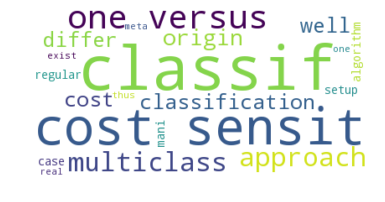

In [11]:
from wordcloud import WordCloud
## plot the first document
wordcloud = WordCloud(background_color="white", max_words=20)
wordcloud.generate(corpus_stemmed_nodigits[0])
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 3. Run LDA

In [12]:
from sklearn.decomposition import LatentDirichletAllocation
## large n will produce fine-grained topics
## small n will produce coarse-grained topics
lda = LatentDirichletAllocation(n_topics=5)
corpus_lda = lda.fit_transform(corpus_counter)

/Users/zhiyzuo/.virtualenvs/PyEnv/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [13]:
def print_top_words(model, feature_names, n_top_words):
    top_word_list = []
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        top_words = [feature_names[i] \
                     for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(" ".join(top_words))
        top_word_list.append(top_words)
        
    return top_word_list

In [14]:
top_word_list = print_top_words(lda, words, 10)

Topic #0:
model method algorithm thi optim problem propos use random function
Topic #1:
data thi use problem algorithm class learn cluster method label
Topic #2:
data asymptot function svm bandit process imbalanc machin high log
Topic #3:
learn algorithm thi approach use problem dictionari model method dimension
Topic #4:
learn model estim distribut data use sampl algorithm propos function


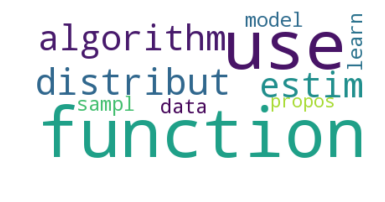

In [15]:
lda_wordcloud = WordCloud(background_color="white", max_words=10, relative_scaling=0)
lda_wordcloud.generate(' '.join(top_word_list[4]))
import matplotlib.pyplot as plt
plt.imshow(lda_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 4. Conclusion

Of course there are a lot of things to do. We can, for example, compare the document similarity across the latent topic space. To interprete the meaning of the topics corresponding to the top keywords, we may need to rerun LDA with different number of topics. This tutorial provides a simple procedure on how we can conduct text analyses in Python (in this case, dimensionality reduction by mapping document and words onto a lower-dimemnsion topic space).

Finally, let's try to use a fantastic tool `pyLDAVis`. See <a href="http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb" target="_blank">here</a> for a more detailed example. 

In [16]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-04-02 12:46:30.037483. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [17]:
pyLDAvis.sklearn.prepare(lda, corpus_counter, counter)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      35.669833        1       1  0.041618  0.007904
3      22.164054        1       2 -0.058040 -0.028492
4      19.239510        1       3  0.033887  0.056230
0      18.426989        1       4  0.037497 -0.063239
2       4.499614        1       5 -0.054963  0.027596, topic_info=     Category       Freq        Term      Total  loglift  logprob
term                                                             
170   Default  82.000000        data  82.000000  30.0000  30.0000
207   Default  27.000000   distribut  27.000000  29.0000  29.0000
290   Default  39.000000    function  39.000000  28.0000  28.0000
706   Default  12.000000         svm  12.000000  27.0000  27.0000
380   Default  77.000000       learn  77.000000  26.0000  26.0000
540   Default  11.000000     process  11.000000  25.0000  25.0000
399   Default  27.000000      machin  27.000000  24.0000  24.0000
623   Default  32.000000       sampl  32.000000  23.0000  23.0000
393   Default  10.000000         log  10.000000  22.0000  22.0000
58    Default   8.000000      bandit   8.000000  21.0000  21.0000
239   Default  33.000000       estim  33.000000  20.0000  20.0000
51    Default   5.000000    asymptot   5.000000  19.0000  19.0000
319   Default  16.000000        high  16.000000  18.0000  18.0000
331   Default   6.000000    imbalanc   6.000000  17.0000  17.0000
487   Default  29.000000       optim  29.000000  16.0000  16.0000
104   Default  19.000000     classif  19.000000  15.0000  15.0000
515   Default  11.000000       point  11.000000  14.0000  14.0000
199   Default  21.000000   dimension  21.000000  13.0000  13.0000
193   Default  13.000000  dictionari  13.000000  12.0000  12.0000
101   Default  38.000000       class  38.000000  11.0000  11.0000
105   Default   9.000000    classifi   9.000000  10.0000  10.0000
639   Default   7.000000      sensit   7.000000   9.0000   9.0000
586   Default  10.000000     regress  10.000000   8.0000   8.0000
152   Default   4.000000    contextu   4.000000   7.0000   7.0000
266   Default   6.000000      famili   6.000000   6.0000   6.0000
147   Default   7.000000  constraint   7.000000   5.0000   5.0000
34    Default  15.000000      applic  15.000000   4.0000   4.0000
21    Default   8.000000          al   8.000000   3.0000   3.0000
548   Default  13.000000    properti  13.000000   2.0000   2.0000
173   Default   8.000000       decis   8.000000   1.0000   1.0000
...       ...        ...         ...        ...      ...      ...
746    Topic5   0.595093  understand   2.822505   1.5445  -6.1332
279    Topic5   1.040121     flexibl   4.966511   1.5378  -5.5749
435    Topic5   0.592131    mixtures   2.865770   1.5243  -6.1382
540    Topic5   2.343000     process  11.374569   1.5212  -4.7628
471    Topic5   1.080370      normal   5.792661   1.4219  -5.5369
409    Topic5   1.021183      margin   5.743219   1.3741  -5.5932
456    Topic5   0.641389        near   3.614954   1.3720  -6.0583
109    Topic5   0.987790       close   5.715475   1.3457  -5.6265
639    Topic5   1.350558      sensit   7.883021   1.3370  -5.3137
242    Topic5   1.095357          et   6.445074   1.3289  -5.5231
515    Topic5   1.795605       point  11.459964   1.2477  -5.0289
319    Topic5   2.174661        high  16.226688   1.0914  -4.8373
763    Topic5   1.087788     varianc   6.424511   1.3252  -5.5301
105    Topic5   1.463378    classifi   9.771143   1.2025  -5.2335
586    Topic5   1.554239     regress  10.969332   1.1471  -5.1732
649    Topic5   1.440095       sever  10.173289   1.1461  -5.2495
170    Topic5   4.343095        data  82.032645   0.1626  -4.1456
399    Topic5   2.235155      machin  27.059992   0.6074  -4.8099
290    Topic5   2.753431    function  39.569877   0.4360  -4.6014
147    Topic5   1.135873  constraint   7.924826   1.1586  -5.4868
548    Topic5   1.517404    properti  13.418500   0.9215  -5.1972
104    Topic5  

/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-04-02 12:46:30.658884. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Reference:

[1] Deerwester, S., Dumais, S. T., Furnas, G. W., Landauer, T. K., & Harshman, R. (1990). Indexing by latent semantic analysis. Journal of the American society for information science, 41(6), 391.

[2] Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. Journal of machine Learning research, 3(Jan), 993-1022.